In [3]:
!git init -q
!git config --local user.email "ssv273@yandex.ru"
!git config --local user.name "ssv-nsk"
!dvc init -q
!git commit -m "DVC init"

Текущая ветка: main
Эта ветка соответствует «origin/main».

Неотслеживаемые файлы:
  (используйте «git add <файл>...», чтобы добавить в то, что будет включено в коммит)
	.dvc/
	.dvcignore
	1.ipynb
	requirements.txt
	yolo11s.pt

индекс пуст, но есть неотслеживаемые файлы
(используйте «git add», чтобы проиндексировать их)


In [4]:
!mkdir raw_data/raw_dataset
!unzip raw_data/test.v4i.yolov11.zip -d raw_data/raw_dataset
%pip install -r requirements.txt

Archive:  raw_data/test.v4i.yolov11.zip
  inflating: raw_data/raw_dataset/README.dataset.txt  
  inflating: raw_data/raw_dataset/README.roboflow.txt  
  inflating: raw_data/raw_dataset/data.yaml  
   creating: raw_data/raw_dataset/train/
   creating: raw_data/raw_dataset/train/images/
 extracting: raw_data/raw_dataset/train/images/1_MOV-0000_jpg.rf.97d4acb1d1e410965c65681b3d190a06.jpg  
 extracting: raw_data/raw_dataset/train/images/1_MOV-0004_jpg.rf.0bd7dc6ac54f9d9f1bb47a25222e6964.jpg  
 extracting: raw_data/raw_dataset/train/images/1_MOV-0005_jpg.rf.5b2475cc62caf564db3d748f692a6f68.jpg  
 extracting: raw_data/raw_dataset/train/images/1_MOV-0007_jpg.rf.b45279ed7e3241151188cb4ad8dcaed8.jpg  
 extracting: raw_data/raw_dataset/train/images/1_MOV-0009_jpg.rf.a13608a35dbe48091e7f5121dea4b2f6.jpg  
 extracting: raw_data/raw_dataset/train/images/1_MOV-0011_jpg.rf.637158bd8860f55e3b5747402ae00f9c.jpg  
 extracting: raw_data/raw_dataset/train/images/2_1_MOV-0000_jpg.rf.5ab96cd2b2737f20e486910

In [5]:
import os
import random
import shutil
import yaml

import albumentations as A
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import imageio.v2 as imageio
from PIL import Image
from ultralytics import YOLO



# Augmentation

In [6]:
# для начала считаем все имена файлов и их аннотаций в pandas.DataFrame
images_path = "./raw_data/raw_dataset/train/images/"
annot_path = "./raw_data/raw_dataset/train/labels/"

images = sorted([i for i in os.listdir(images_path) if i.endswith(".jpg")])
annot = sorted([i for i in os.listdir(annot_path) if i.endswith(".txt")])
print("Всего файлов: ", len(images))
print("Всего аннотаций: ", len(annot))

Всего файлов:  90
Всего аннотаций:  90


In [7]:
img_df = pd.DataFrame(data=images, columns=['img_name'])
img_df['annot_name'] = annot
img_df.head(2)

,img_name,annot_name
0,1_MOV-0000_jpg.rf.97d4acb1d1e410965c65681b3d19...,1_MOV-0000_jpg.rf.97d4acb1d1e410965c65681b3d19...
1,1_MOV-0004_jpg.rf.0bd7dc6ac54f9d9f1bb47a25222e...,1_MOV-0004_jpg.rf.0bd7dc6ac54f9d9f1bb47a25222e...


#### определим вспомогательные функции для визуализации

In [8]:
BOX_COLOR = (255, 0, 0)  # Red
TEXT_COLOR = (255, 255, 255)  # White

In [9]:
def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x, y, w, h = bbox
    dh, dw, _ = img.shape


    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)
    
    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1

    cv2.rectangle(img, (l, t), (r, b), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (l, t - int(1.3 * text_height)), (l + text_width, t), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(l, t - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img

In [10]:
def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        if category_id == '1':
            img = visualize_bbox(img, bbox, class_name)
        else:
            img = visualize_bbox(img, bbox, class_name, color=(255, 255, 0))

    return img

#### Определим пайплайн для трансформаций

In [11]:
transform = A.Compose(
    [A.HorizontalFlip(p=0.5),
     A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.SquareSymmetry(p=0.5),
    A.OneOf([
        A.ToGray(p=0.1),
        A.ChannelDropout(p=0.1)
    ], p=0.2),
    A.ColorJitter(p=0.1)],
    bbox_params=A.BboxParams(format="yolo", label_fields=["category_ids"]),
    strict=True,
    seed=137,
)

/media/ssv/SHARED/Zebra_test/venv/lib/python3.11/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


#### Возьмём случайное изображение и его баундинг боксы

In [44]:
category_id_to_name = {'2': "cup/saucer", '1': "teapot", "0": 'borsch', "3": 'meat',
                      "4": "salad", "5": "salad_2", "6": "soup"}

In [ ]:
random_image = img_df.sample(1)
img = imageio.imread(images_path + random_image.values[0][0])
with open(annot_path + random_image.values[0][1], "r") as f:
    raw_bbxs = f.readlines()
    
category_ids = []
bboxes = []
for line in raw_bbxs:
    bb_ = line.strip().split()
    category_ids.append(bb_[0])
    bboxes.append([float(x) for x in bb_[1:]])
['borsch', 'glass teapot', 'glass_cape', 'meat', 'salad', 'salad_2', 'soup']


#### Визуализируем трансформации

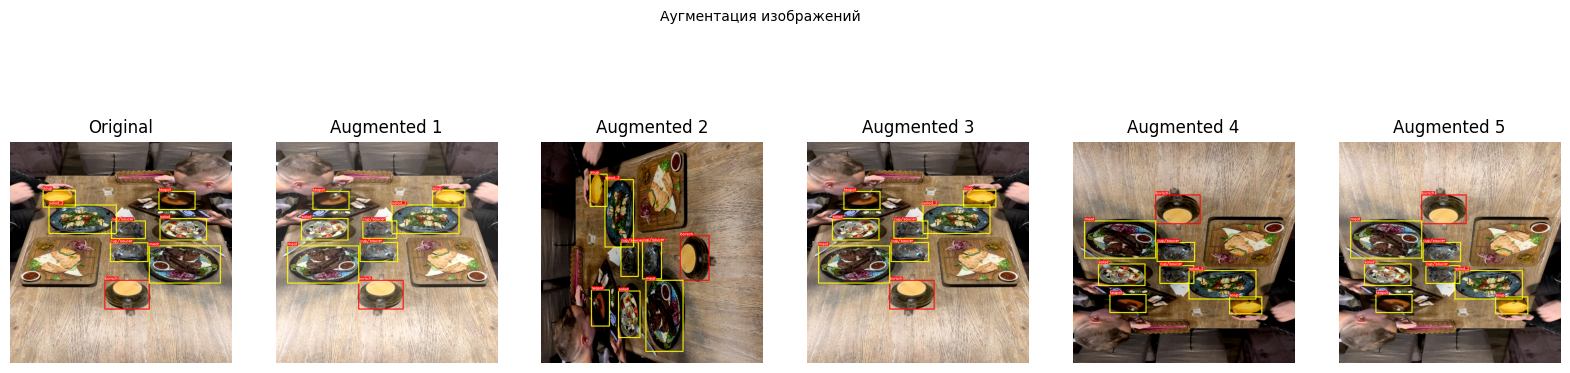

In [13]:
samples = 5
figure, ax = plt.subplots(1, samples + 1, figsize=(20, 5))
figure.suptitle('Аугментация изображений', fontsize=10)

ax[0].imshow(visualize(img, bboxes, category_ids, category_id_to_name))
ax[0].set_title("Original")
ax[0].axis("off")

# Draw augmented samples
for i in range(samples):
    try:
        transformed = transform(image=img, bboxes=bboxes, category_ids=category_ids)
        ax[i+1].imshow(visualize(
                    transformed["image"],
                    transformed["bboxes"],
                    transformed["category_ids"],
                    category_id_to_name,
                ))
        ax[i+1].set_title(f"Augmented {i+1}")
    except Exception as e:
        print(f"Error during augmentation sample {i+1}: {e}")
        ax[i+1].imshow(img) # Show original on error
        ax[i+1].set_title(f"Aug Error {i+1}")
    finally:
        ax[i+1].axis("off")


#### Теперь к каждому изображению применим трансформацию по два раза, таким образом количество изображений увеличится в три раза

In [14]:
# Создание директории для сохранения изображений
directory = './raw_data/dataset/augmented_images/'
directory_labels = './raw_data/dataset/augmented_labels/'
os.makedirs(directory, exist_ok=True)
os.makedirs(directory_labels, exist_ok=True)

In [15]:
def save_data(img, category_ids, bboxes, save_image_name, save_annot_name, file_directory=directory, annot_directory=directory_labels):
    """
    save image and annotations
    """
    img_to_save = Image.fromarray(img)
    image_path_to_save = os.path.join(file_directory, save_image_name)
    img_to_save.save(image_path_to_save)

    annot_path_to_write = os.path.join(annot_directory, save_annot_name)
    with open(annot_path_to_write, 'w') as file:
        for i in range(len(category_ids)):
            ann = list(category_ids[i])
            ann.extend(bboxes[i])
            # print(ann)
            file.write(' '.join(map(str, ann)) + '\n')


In [16]:
for i in img_df.iterrows():
    # сначала просто копируем оригинайльный файл в новую директорию
    file_path = images_path + i[1]['img_name']
    destination_dir = directory
    annot_file_path = annot_path + i[1]['annot_name']
    annot_destination_dir = directory_labels
    
    shutil.copy(file_path, destination_dir)
    shutil.copy(annot_file_path, annot_destination_dir)

    # считываем данные
    img = imageio.imread(file_path)

    with open(annot_file_path, "r") as f:
        raw_bbxs = f.readlines()
        
    category_ids = []
    bboxes = []
    for line in raw_bbxs:
        bb_ = line.strip().split()
        category_ids.append(bb_[0])
        bboxes.append([float(x) for x in bb_[1:]])

    # теперь применяем преобразования к исходному изображению два раза, чтобы получить три разных изображения из одного
    for j in range(2):
        transformed = transform(image=img, bboxes=bboxes, category_ids=category_ids)
        new_image_name = i[1]['img_name'].split(".jpg")[0] + f"_{j}.jpg"
        new_annot_name = i[1]['annot_name'].split(".txt")[0] + f"_{j}.txt"
        save_data(transformed["image"], 
                  transformed["category_ids"], 
                  transformed["bboxes"], 
                  new_image_name, 
                  new_annot_name
                  )

#### проверка

In [17]:
# проверим сколько в итоге получилось файлов

images = sorted([i for i in os.listdir(directory) if i.endswith(".jpg")])
annot = sorted([i for i in os.listdir(directory_labels) if i.endswith(".txt")])
print("Всего файлов: ", len(images))
print("Всего аннотаций: ", len(annot))

Всего файлов:  270
Всего аннотаций:  270


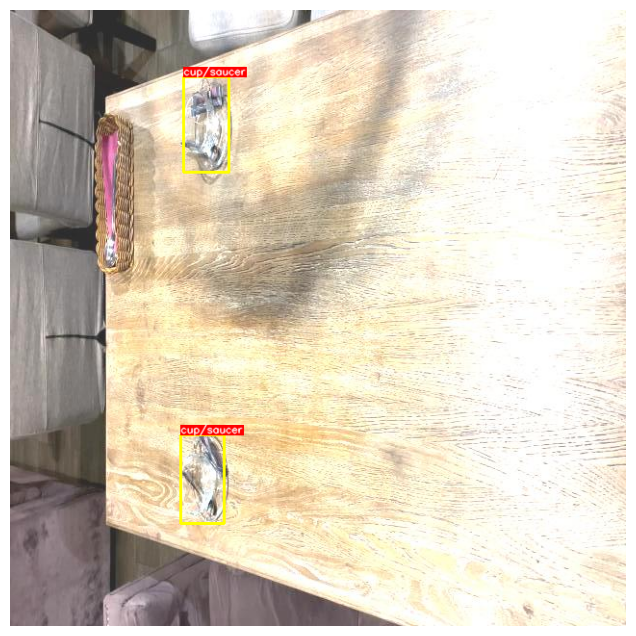

In [18]:
img = imageio.imread("raw_data/dataset/augmented_images/1_MOV-0000_jpg.rf.97d4acb1d1e410965c65681b3d190a06_0.jpg")
with open("raw_data/dataset/augmented_labels/1_MOV-0000_jpg.rf.97d4acb1d1e410965c65681b3d190a06_0.txt", "r") as f:
    raw_bbxs = f.readlines()
    
category_ids = []
bboxes = []
for line in raw_bbxs:
    bb_ = line.strip().split()
    category_ids.append(bb_[0])
    bboxes.append([float(x) for x in bb_[1:]])

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(visualize(img,bboxes, category_ids, category_id_to_name));

# Разделение на train/val/test

In [19]:
# Задаем пути к исходным и целевым папкам
dataset_path = './raw_data/dataset'
augmented_images_path = os.path.join(dataset_path, 'augmented_images')
augmented_labels_path = os.path.join(dataset_path, 'augmented_labels')
final_dataset_path = 'datasets'

In [20]:
# Создаем структуру финальной папки
os.makedirs(os.path.join(final_dataset_path, 'train', 'images'), exist_ok=True)
os.makedirs(os.path.join(final_dataset_path, 'train', 'labels'), exist_ok=True)
os.makedirs(os.path.join(final_dataset_path, 'valid', 'images'), exist_ok=True)
os.makedirs(os.path.join(final_dataset_path, 'valid', 'labels'), exist_ok=True)
os.makedirs(os.path.join(final_dataset_path, 'test', 'images'), exist_ok=True)
os.makedirs(os.path.join(final_dataset_path, 'test', 'labels'), exist_ok=True)

In [21]:
# Получаем список всех изображений
image_files = [f for f in os.listdir(augmented_images_path) if f.endswith('.jpg')]

# Перемешиваем список изображений
random.shuffle(image_files)

In [22]:
# Определяем размеры для разделения
total_images = len(image_files)
train_size = int(total_images * 0.7)
valid_size = int(total_images * 0.2)

# Получаем файлы для каждой части
train_files = image_files[:train_size]
valid_files = image_files[train_size:train_size + valid_size]
test_files = image_files[train_size + valid_size:]
print("total files: ", len(train_files) + len(valid_files) + len(test_files))

total files:  270


In [23]:
def copy_files(files, src_dir, dest_dir):
    for file in files:
        # Копируем изображение
        shutil.copy(os.path.join(src_dir, file), os.path.join(dest_dir, file))
        # Копируем соответствующий файл .txt
        label_file = file.replace('.jpg', '.txt')
        shutil.copy(os.path.join(augmented_labels_path, label_file), os.path.join(dest_dir.replace('images', 'labels'), label_file))

In [24]:
# Копируем файлы в нужные директории
copy_files(train_files, augmented_images_path, os.path.join(final_dataset_path, 'train', 'images'))
copy_files(valid_files, augmented_images_path, os.path.join(final_dataset_path, 'valid', 'images'))
copy_files(test_files, augmented_images_path, os.path.join(final_dataset_path, 'test', 'images'))

### для запуска обучения еще нужен файлик .yaml с метаданными

In [25]:
data = {
    'train': '../train/images',
    'val': '../valid/images',
    'test': '../test/images',
    'nc': 7,
    'names': ['borsch', 'glass_teapot', 'cup/saucer', 'meat', 'salad', 'salad_2', 'soup']
}

with open(final_dataset_path + '/data.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False, allow_unicode=True)

In [26]:
# удаляем ненужные данные
!rm -rf raw_data/raw_dataset
!rm -rf raw_data/dataset

# Запуск обучения

In [27]:
HOME = os.getcwd()
dataset_location = HOME + "/datasets"
dataset_location

'/media/ssv/SHARED/Zebra_test/test_zebra/datasets'

In [28]:
!yolo settings sync=False
import ultralytics
ultralytics.checks()

Ultralytics 8.3.159 🚀 Python-3.11.11 torch-2.7.1+cu126 CPU (Intel Core(TM) i7-8550U 1.80GHz)
Setup complete ✅ (8 CPUs, 15.5 GB RAM, 140.6/191.4 GB disk)


## Baseline
#### в качестве начальной точки отсчета метрик возьмем все значения для YOLO по умолчанию

In [29]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset_location}/data.yaml epochs=10 imgsz=640 plots=True

/media/ssv/SHARED/Zebra_test/test_zebra
New https://pypi.org/project/ultralytics/8.3.161 available 😃 Update with 'pip install -U ultralytics'
/media/ssv/SHARED/Zebra_test/venv/lib/python3.11/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
Ultralytics 8.3.159 🚀 Python-3.11.11 torch-2.7.1+cu126 CPU (Intel Core(TM) i7-8550U 1.80GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste

#### попробуем изменить гиперпараметры

In [30]:
%cd {HOME}
# добавим дропаут и поменяем оптимизатор и learning rate вместе с моментом инерции
# дропаут заставит модель больше генерализировать признаки, а не заучивать их
# learning rate вместе с моментом инерции мы уменьшим, для более плавного спуска в глобальный минимум
!yolo task=detect mode=train model=yolo11s.pt data={dataset_location}/data.yaml epochs=10 imgsz=640 plots=True dropout=0.1 optimizer=Adam lr0=0.001 momentum=0.85

/media/ssv/SHARED/Zebra_test/test_zebra
New https://pypi.org/project/ultralytics/8.3.161 available 😃 Update with 'pip install -U ultralytics'
/media/ssv/SHARED/Zebra_test/venv/lib/python3.11/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
Ultralytics 8.3.159 🚀 Python-3.11.11 torch-2.7.1+cu126 CPU (Intel Core(TM) i7-8550U 1.80GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste

#### попробуем более тяжелую модель

In [31]:
!yolo task=detect mode=train model=yolo11m.pt data={dataset_location}/data.yaml epochs=10 imgsz=640 plots=True

100%|██████████████████████████████████████| 38.8M/38.8M [00:02<00:00, 14.6MB/s]
New https://pypi.org/project/ultralytics/8.3.161 available 😃 Update with 'pip install -U ultralytics'
/media/ssv/SHARED/Zebra_test/venv/lib/python3.11/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
Ultralytics 8.3.159 🚀 Python-3.11.11 torch-2.7.1+cu126 CPU (Intel Core(TM) i7-8550U 1.80GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_

# Предсказания

In [32]:
# возьмем базовую модель
model = YOLO('./runs/detect/train/weights/best.pt')

In [33]:
# для начала считаем все имена тестовых файлов и их аннотаций в pandas.DataFrame
images_path = "./datasets/test/images/"
annot_path = "./datasets/test/labels/"

test_images = sorted([i for i in os.listdir(images_path) if i.endswith(".jpg")])
test_annot = sorted([i for i in os.listdir(annot_path) if i.endswith(".txt")])
print("Всего тестовых файлов: ", len(test_images))
print("Всего тестовых аннотаций: ", len(test_annot))

Всего тестовых файлов:  27
Всего тестовых аннотаций:  27


In [34]:
test_img_df = pd.DataFrame(data=test_images, columns=['img_name'])
test_img_df['annot_name'] = test_annot
test_img_df.head(2)

,img_name,annot_name
0,1_MOV-0005_jpg.rf.5b2475cc62caf564db3d748f692a...,1_MOV-0005_jpg.rf.5b2475cc62caf564db3d748f692a...
1,1_MOV-0007_jpg.rf.b45279ed7e3241151188cb4ad8dc...,1_MOV-0007_jpg.rf.b45279ed7e3241151188cb4ad8dc...


In [46]:
random_image = test_img_df.sample(1)
img = imageio.imread(images_path + random_image.values[0][0])
with open(annot_path + random_image.values[0][1], "r") as f:
    raw_bbxs = f.readlines()
    
test_category_ids = []
test_bboxes = []
for line in raw_bbxs:
    bb_ = line.strip().split()
    test_category_ids.append(bb_[0])
    test_bboxes.append([float(x) for x in bb_[1:]])


In [47]:
# предсказания модели
results = model.predict(source=img, conf=0.5, save=False, device="cpu")


0: 640x640 1 borsch, 1 glass_teapot, 2 cup/saucers, 1 meat, 1 salad, 1 salad_2, 1 soup, 325.7ms
Speed: 24.5ms preprocess, 325.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


In [48]:
# баундинг боксы хранятся тут
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([2., 0., 2., 1., 6., 5., 3., 4.])
conf: tensor([0.9376, 0.9287, 0.9239, 0.9175, 0.8372, 0.8360, 0.8179, 0.8044])
data: tensor([[291.5813, 231.2324, 389.8320, 281.1725,   0.9376,   2.0000],
        [449.6292, 147.0028, 553.8350, 200.9594,   0.9287,   0.0000],
        [286.1319, 293.9812, 397.0957, 349.0070,   0.9239,   2.0000],
        [274.0567, 400.7424, 400.1512, 486.0558,   0.9175,   1.0000],
        [110.1653, 147.2186, 201.7391, 196.4452,   0.8372,   6.0000],
        [ 59.8803, 197.7865, 260.1179, 276.6104,   0.8360,   5.0000],
        [396.9183, 303.9938, 602.0054, 409.9304,   0.8179,   3.0000],
        [430.9368, 223.7780, 567.4827, 285.0471,   0.8044,   4.0000]])
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([8, 6])
xywh: tensor([[340.7067, 256.2025,  98.2507,  49.9402],
        [501.7321, 173.9811, 104.2057,  53.9565],
        [341.6138, 321.4941, 110.9638,  55.0258],
        [337.1040, 4

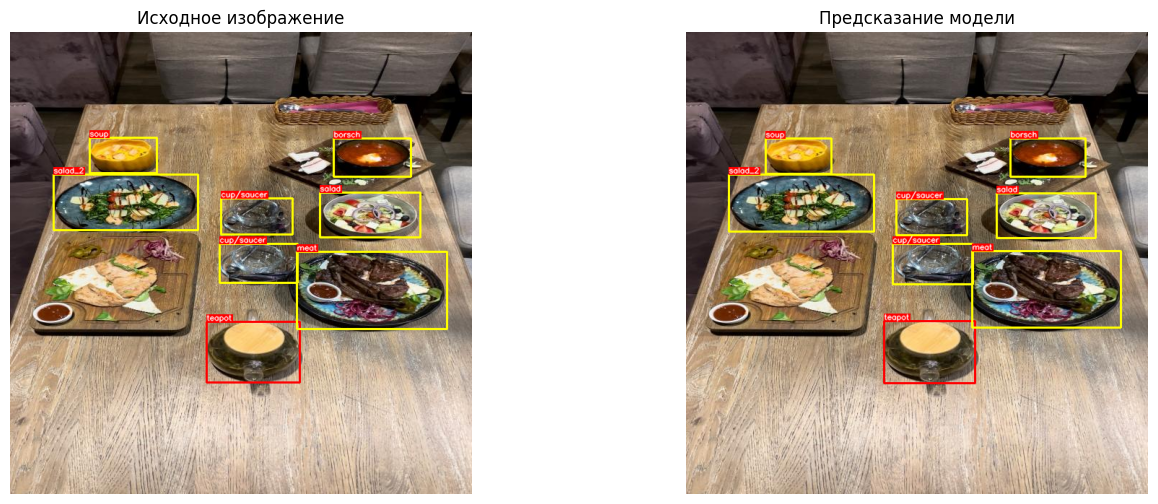

In [49]:
# отрисуем предсказания
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ax1.imshow(visualize(img,
                     test_bboxes, 
                     test_category_ids, 
                     category_id_to_name))
ax1.set_title('Исходное изображение')
ax1.axis("off")

ax2.imshow(visualize(img,
                     results[0].boxes.xywhn.cpu().numpy(), 
                     results[0].boxes.cls.cpu().numpy().astype("int").astype("str"), 
                     category_id_to_name))
ax2.set_title('Предсказание модели')
ax2.axis("off");

# Метрики

In [50]:
baseline_model = YOLO('./runs/detect/train/weights/best.pt')
baseline_metrics = baseline_model.val(data="./datasets/data.yaml", split='test', verbose=False, name='baseline')

model_1 = YOLO('./runs/detect/train2/weights/best.pt')
metrics_1 = model_1.val(data="./datasets/data.yaml", split='test', verbose=False, name='model_1')

model_2 = YOLO('./runs/detect/train3/weights/best.pt')
metrics_2 = model_2.val(data="./datasets/data.yaml", split='test', verbose=False, name='model_2')

Ultralytics 8.3.159 🚀 Python-3.11.11 torch-2.7.1+cu126 CPU (Intel Core(TM) i7-8550U 1.80GHz)
YOLO11s summary (fused): 100 layers, 9,415,509 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 760.7±910.4 MB/s, size: 82.2 KB)


val: Scanning /media/ssv/SHARED/Zebra_test/test_zebra/datasets/test/labels... 27

val: New cache created: /media/ssv/SHARED/Zebra_test/test_zebra/datasets/test/labels.cache



/media/ssv/SHARED/Zebra_test/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         27        150      0.933      0.988      0.965      0.913
Speed: 2.1ms preprocess, 222.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/baseline
Ultralytics 8.3.159 🚀 Python-3.11.11 torch-2.7.1+cu126 CPU (Intel Core(TM) i7-8550U 1.80GHz)
YOLO11s summary (fused): 100 layers, 9,415,509 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2101.6±595.1 MB/s, size: 76.5 KB)


val: Scanning /media/ssv/SHARED/Zebra_test/test_zebra/datasets/test/labels.cache
/media/ssv/SHARED/Zebra_test/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         27        150      0.922      0.979      0.972      0.901
Speed: 1.9ms preprocess, 203.4ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/model_1
Ultralytics 8.3.159 🚀 Python-3.11.11 torch-2.7.1+cu126 CPU (Intel Core(TM) i7-8550U 1.80GHz)
YOLO11m summary (fused): 125 layers, 20,035,429 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2486.0±344.5 MB/s, size: 81.8 KB)


val: Scanning /media/ssv/SHARED/Zebra_test/test_zebra/datasets/test/labels.cache
/media/ssv/SHARED/Zebra_test/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         27        150       0.92      0.988      0.969        0.9
Speed: 3.0ms preprocess, 499.8ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/model_2


#### здесь лежат все метрики

In [51]:
baseline_metrics

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f4866316490>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

#### можно построить самостоятельно графики

In [52]:
baseline_metrics.curves

['Precision-Recall(B)',
 'F1-Confidence(B)',
 'Precision-Confidence(B)',
 'Recall-Confidence(B)']

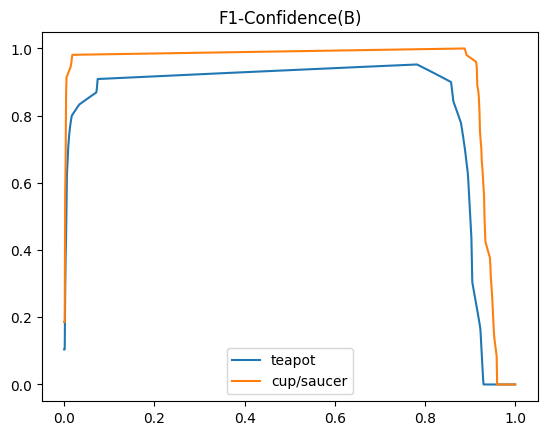

In [53]:
# например построим график для 'F1-Confidence(B)'

plt.plot(baseline_metrics.curves_results[1][0], baseline_metrics.curves_results[1][1][0], label='teapot')
plt.plot(baseline_metrics.curves_results[1][0], baseline_metrics.curves_results[1][1][1], label='cup/saucer')
plt.title(baseline_metrics.curves[1])
plt.legend()
plt.show()


или посмотреть на сохраненные автоматически в более презентабельном виде   
<img src="./runs/detect/baseline/F1_curve.png" alt="описание изображения" width="50%">  


## для более удобного анализа есть dvclive

#### здесь мы можем посмотреть все метрики по всем экспериментам наглядно

In [54]:
import dvc.api
import pandas as pd

# Define the columns of interest
columns = ["Experiment", "model", 'metrics.precision(B)', 
           'metrics.recall(B)', 'metrics.mAP50(B)', "metrics.mAP50-95(B)"]

# Retrieve experiment data
df = pd.DataFrame(dvc.api.exp_show(), columns=columns)

# Clean the data
df.dropna(inplace=True)

# Display the DataFrame
df.sort_index(ascending=False).reset_index(drop=True)

,Experiment,model,metrics.precision(B),metrics.recall(B),metrics.mAP50(B),metrics.mAP50-95(B)
0,shyer-suqs,yolo11s.pt,0.906350,0.992294,0.950838,0.870629
1,honey-lama,yolo11s.pt,0.915816,0.982604,0.971082,0.886844
2,buggy-tilt,yolo11s.pt,0.932426,0.982732,0.977535,0.903056
3,wrong-phon,yolo11m.pt,0.939448,0.937320,0.976915,0.882909


In [55]:
# Generate DVC comparative plots
!dvc plots diff $(dvc exp list --names-only)

file:///media/ssv/SHARED/Zebra_test/test_zebra/dvc_plots/index.html             


In [56]:
from IPython.display import HTML

# Display the DVC plots as HTML
HTML(filename="./dvc_plots/index.html")

#### краткий анализ метрик

In [57]:
baseline_metrics.results_dict

{'metrics/precision(B)': np.float64(0.932741114403947),
 'metrics/recall(B)': np.float64(0.9879969256280274),
 'metrics/mAP50(B)': np.float64(0.9650836570929383),
 'metrics/mAP50-95(B)': np.float64(0.9132147057636849),
 'fitness': np.float64(0.9184016008966103)}

In [60]:
res_df = pd.DataFrame([baseline_metrics.results_dict, metrics_1.results_dict,  metrics_2.results_dict])
res_df['model'] = ['baseline', 'model_1', 'model_2']
res_df[['model', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'fitness']]

,model,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),fitness
0,baseline,0.932741,0.987997,0.965084,0.913215,0.918402
1,model_1,0.922020,0.979027,0.972236,0.901101,0.908214
2,model_2,0.919973,0.987607,0.968981,0.899757,0.906679


Анализируя представленные результаты трёх экспериментов по детектированию объектов с использованием алгоритма YOLO, можно сделать следующие выводы:

▌ Основные показатели качества модели:

- Precision — доля правильно предсказанных объектов среди всех обнаруженных (чем ближе к 1, тем лучше).
- Recall — доля действительно присутствующих объектов, которые были успешно обнаружены моделью (чем ближе к 1, тем лучше).
- mAP50 — средняя точность обнаружения при IoU=0.5 (важнейший показатель общей точности модели).
- mAP50-95 — среднее значение mAP при различных порогах IoU от 0.5 до 0.95 (оценивает устойчивость модели к различным уровням перекрытий между объектами).
- Fitness — интегральный показатель качества модели, объединяющий Precision, Recall и mAP.

▌ Выводы по результатам эксперимента:

▌ 1. Baseline vs Model\_1

- Модель Baseline показывает лучшие значения precision и recall, однако её mAP50 ниже, чем у Model\_1. Это значит, что хотя базовая модель точнее определяет объекты и реже делает ложные срабатывания, её общая способность находить все объекты хуже, чем у первой модификации (Model\_1). Следовательно, Model\_1 является предпочтительной благодаря лучшей способности распознавать большее количество объектов при сохранении приемлемого уровня точности.

▌ 2. Baseline vs Model\_2

- Model\_2, несмотря на схожее высокое значение recall, имеет заметно худшие показатели mAP50 и mAP50-95 относительно базовой модели. Её интегральная оценка Fitness также значительно ниже. Таким образом, хотя модель находит почти столько же объектов, как и базовая версия, её качество общего обнаружения значительно ниже, особенно при увеличении порога перекрытия (IoU), что снижает общую полезность модели.

▌ 3. Model\_1 vs Model\_2

- Между этими двумя моделями разница заключается в уровне mAP50 и mAP50-95. Хотя обе показывают близкие значения precision и recall, первая модификация существенно превосходит вторую по общей эффективности распознавания объектов при разных уровнях перекрытия. Именно поэтому Model\_1 демонстрирует лучшее общее качество и должна рассматриваться как наиболее эффективная модификация.

▌ Итоги:

Исходя из анализа представленных метрик, наилучшей представляется Model\_1, поскольку она обеспечивает оптимальное сочетание высокой точности (precision), полноты (recall) и хорошей производительности (mAP50 и mAP50-95), что подтверждает её превосходство над остальными вариантами моделей.

# Оптимизация гиперпараметров

в YOLO есть встроенный поиск оптимальных гиперпараметров на основе генетических алгоритмов.  
Раньше я делал это вручную (https://github.com/ssv-nsk/genetic/blob/main/%D0%93%D0%B5%D0%BD%D0%B5%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5%20%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D1%8B%20%D0%B4%D0%BB%D1%8F%20%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85%20%D1%81%D0%B5%D1%82%D0%B5%D0%B9.ipynb)

In [ ]:
# попробуем еще немного опртимизировать модель 1
model_1 = YOLO('./runs/detect/train2/weights/best.pt')

# Define search space
search_space = {
    "lr0": (1e-5, 1e-1),
    "momentum": (0.7, 0.98),
     "degrees": (0.0, 45.0), # Максимальное увеличение поворота в градусах. Помогает модели стать инвариантной к ориентации объекта
}

# Tune hyperparameters for 10 epochs
model_1.tune(
    data="./datasets/data.yaml",
    epochs=10,
    iterations=100,
    optimizer="Adam",
    space=search_space,
    plots=True,
    save=True,
    val=True,
)

вырезан выход этой ячейки, так как он очень большой

In [66]:
tuned_model_1 = YOLO('./runs/detect/tune2/weights/best.pt')
tuned_metrics_1 = tuned_model_1.val(data="./datasets/data.yaml", split='test', verbose=False, name='tuned_model_1')

Ultralytics 8.3.159 🚀 Python-3.11.11 torch-2.7.1+cu126 CPU (Intel Core(TM) i7-8550U 1.80GHz)
YOLO11s summary (fused): 100 layers, 9,415,509 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 372.5±44.5 MB/s, size: 84.2 KB)


val: Scanning /media/ssv/SHARED/Zebra_test/test_zebra/datasets/test/labels.cache
/media/ssv/SHARED/Zebra_test/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all         27        150      0.949      0.961      0.978       0.93
Speed: 1.9ms preprocess, 281.5ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/tuned_model_12


In [67]:
res_df = pd.DataFrame([baseline_metrics.results_dict, metrics_1.results_dict,  
                       metrics_2.results_dict, tuned_metrics_1.results_dict])
res_df['model'] = ['baseline', 'model_1', 'model_2', 'tuned_metrics_1']
res_df[['model', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'fitness']]

,model,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),fitness
0,baseline,0.932741,0.987997,0.965084,0.913215,0.918402
1,model_1,0.922020,0.979027,0.972236,0.901101,0.908214
2,model_2,0.919973,0.987607,0.968981,0.899757,0.906679
3,tuned_metrics_1,0.949235,0.961105,0.978213,0.930258,0.935054


После подбора гиперпараметров tuned_model_1 значительно повысила точность по сравнению с baseline (на 0.016494 в precision) и довольно близка к baseline по recall. Это говорит о том, что определенные настройки и улучшения в модели могли привести к существенному улучшению общей производительности, особенно в условиях, когда важна точность детекции, например, в приложениях, где критично не пропустить объекты.

In [71]:
# наилучшие гиперпараметры
!cat ./runs/detect/tune2/best_hyperparameters.yaml

# 89/100 iterations complete ✅ (152123.09s)
# Results saved to runs/detect/tune2
# Best fitness=0.92011 observed at iteration 54
# Best fitness metrics are {'metrics/precision(B)': 0.94592, 'metrics/recall(B)': 0.96699, 'metrics/mAP50(B)': 0.98347, 'metrics/mAP50-95(B)': 0.91308, 'val/box_loss': 0.47166, 'val/cls_loss': 0.33963, 'val/dfl_loss': 0.86371, 'fitness': 0.92011}
# Best fitness model is runs/detect/train67
# Best fitness hyperparameters are printed below.

lr0: 0.0016
momentum: 0.82693
degrees: 0.0
